# RF_P PYTHON SEQUANA X serial e IPP

## Rodando no nó de login

* o "n_jobs" do Scikit-learn usa por padrão o backend "loky" que por sua vez usa o "fork+exec" do sistema operacional e só funciona em um único nó
* para poder usar processamento distribuido, tem dois backends: Dask e IPP (IPython Parallel)
* tem um exemplo de IPP com SLURM em: [[ULHPC]](https://ulhpc-tutorials.readthedocs.io/en/latest/python/advanced/scikit-learn/)

* ambiente carregado antes do JupyterLab:
```
source $SCR/env2/etc/profile.d/conda.sh
conda activate $SCR/env2
module load openmpi/gnu/4.0.1
```

* de 2022-01-31 até 2022-02-04 os jobs estão parados.
* não dá para rodar no nó de login B710 pois o Intel Turboboost está ligado.
* não dá para rodar no SD18 pois o Intel Hyperthreading está ligado.

### Baixando o dataset

In [9]:
! pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.1-py3-none-any.whl size=14429 sha256=75495f524bf8a1603b76ec180939c5978193c86a440a7de8f42f3e05e0e26725
  Stored in directory: /prj/ampemi/eduardo.miranda2/.cache/pip/wheels/29/0c/4a/58330447f4c918159f819cd72e1fe7d4d2832585a164929f18
Successfully built gdown


In [10]:
! gdown --id 1bfCngu075EjLwQnODqLfTxJDq70-mZtd

Downloading...
From: https://drive.google.com/uc?id=1bfCngu075EjLwQnODqLfTxJDq70-mZtd
To: /prj/ampemi/eduardo.miranda2/rf_p/av_rf_perfomance.zip
100%|████████████████████████████████████████| 655M/655M [00:11<00:00, 55.4MB/s]


In [12]:
! unzip av_rf_perfomance.zip

Archive:  av_rf_perfomance.zip
   creating: av_rf_perfomance/
  inflating: av_rf_perfomance/X_train.npy  
  inflating: av_rf_perfomance/avaliate_speedup_rf_model.py  
  inflating: av_rf_perfomance/y_train.npy  


In [13]:
! mv av_rf_perfomance/*.npy .

copia o dataset para SCRATCH:

In [15]:
! cp *.npy /scratch${PWD#/prj}/

In [16]:
! ls /scratch${PWD#/prj}/

X_train.npy  y_train.npy


mostra algumas informações do dataset:

In [47]:
XTRA = "X_train.npy"
YTRA = "y_train.npy"
x = np.load(XTRA)
y = np.load(YTRA)

In [38]:
x.shape

(10626, 17341)

In [39]:
x.dtype

dtype('float32')

In [40]:
y.shape

(10626,)

In [48]:
y.dtype

dtype('int64')

<hr style="height:10px;border-width:0;background-color:red">

### Usando o backend default

backend default = ("loky")

In [2]:
def rf(num_cores):
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    #carrega os arquivos de treinamento utilizados para avaliar o 
    #desempenho paralelo do modelo de floresta aleatória
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy").astype(int)

    #número de árvores utilizados no algoritmo de floresta aleatória quanto 
    #maior o número de árvores maior o número de tarefas que poderia ser 
    #executado de maneira paralela 
    n_estimators = 50

    #configurações/número de processos avaliados 1, 2, 4, 8, 12, 24
    #num_cores = (argumento da função principal)

    #inicialização do objeto que contém o modelo as árvores somente 
    #serão construídas quando for executado o método fit deste objeto
    model = RandomForestClassifier(random_state=0, 
                                   n_estimators=n_estimators, 
                                   n_jobs=num_cores)

    #Constroi as árvores (treina o modelo)
    model.fit(X_train, y_train)

#### Testes rodando no nó de login

In [15]:
%%timeit -n 1 -r 3
rf(1)

1min 8s ± 10.9 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [16]:
%%timeit -n 1 -r 3
rf(2)

32.1 s ± 223 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [17]:
%%timeit -n 1 -r 3
rf(4)

17.3 s ± 119 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [18]:
%%timeit -n 1 -r 3
rf(8)

9.88 s ± 52.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [3]:
%%timeit -n 1 -r 3
rf(12)

7.61 s ± 571 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [4]:
%%timeit -n 1 -r 3
rf(24)

4.58 s ± 65.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<hr style="height:10px;border-width:0;background-color:red">

### Versão sequencial

In [142]:
%%writefile rf02.py
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
import sys
from time import time
t = -time()

# XTRA = sys.argv[2]
# YTRA = sys.argv[3]
XTRA = "X_train.npy"
YTRA = "y_train.npy"

#carrega os arquivos de treinamento utilizados para avaliar o 
#desempenho paralelo do modelo de floresta aleatória
X_train = np.load(XTRA)
y_train = np.load(YTRA)

#subconjunto para teste (20% de 10626 = ~ 2000)
X_test = X_train[:1999, :]
y_test = y_train[:1999, ]

#número de árvores utilizados no algoritmo de floresta aleatória quanto 
#maior o número de árvores maior o número de tarefas que poderia ser 
#executado de maneira paralela 
n_estimators = 50

#inicialização do objeto que contém o modelo as árvores somente 
#serão construídas quando for executado o método fit deste objeto
model = RandomForestClassifier(random_state=0, 
                               n_estimators=n_estimators)

#Constroi as árvores (treina o modelo)
model.fit(X_train, y_train)

#faz a predição
y_pred_test  = model.predict(X_test)
y_pred_train = model.predict(X_train)

#encontra o erro de classificação para test
accu = metrics.accuracy_score(y_test, y_pred_test, normalize = False)
trsi = y_test.size
etes = ((trsi - accu) / (trsi)) * 100

#encontra o erro de classificação para train
accu = metrics.accuracy_score(y_train, y_pred_train, normalize = False)
trsi = y_train.size
etra = ((trsi - accu) / (trsi)) * 100

#mostra o resultado
t += time()
print(f' Testset classification error is {etra:.2f}% ')
print(f'Trainset classification error is {etes:.2f}% ')
print(f"Elapsed Time: {t:.4f} s")

Overwriting rf02.py


<hr style="height:10px;border-width:0;background-color:red">

### Usando o backend IPP

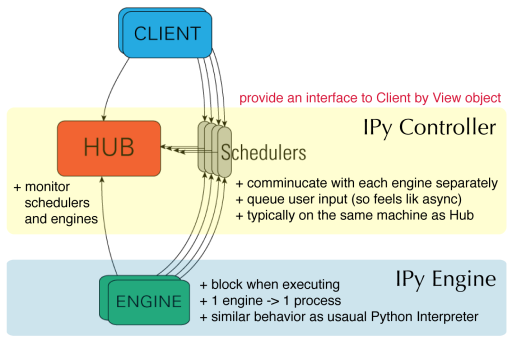

* o Controller roda em um processo
* as Engines rodam em vários processos
* o Controller e as Engines precisam ser carragedas primeiro, antes de executar o programa principal, e ficam rodando em plano de fundo aguardando comandos do Client
* no final precisa terminar explicitamente o Controller e Engines

In [3]:
%%writefile rf01.py
#rf01.py
#número de processos avaliados: 1, 4, 16, 24, 48, 72, 96

#--importa o backend---------------------
from joblib import parallel_backend, register_parallel_backend
from ipyparallel.joblib import IPythonParallelBackend
import ipyparallel as ipp
#----------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
import sys
from time import time
t = -time()

PROF = sys.argv[1]
XTRA = sys.argv[2]
YTRA = sys.argv[3]

#--carrega as Engines-------------------
icli = ipp.Client(profile = PROF)  #nome do ipp profile
ncli = len(icli.ids)               #pega a qtde de motores
bview = icli.load_balanced_view()  #balanceamento de carga
#----------------------------------------

#--define o scikit-learn backend---------
register_parallel_backend('ipyparallel',
    lambda : IPythonParallelBackend(view = bview))
#----------------------------------------

#carrega os arquivos de treinamento utilizados para avaliar o 
#desempenho paralelo do modelo de floresta aleatória
X_train = np.load(XTRA)
y_train = np.load(YTRA)

#subconjunto para teste (20% de 10626 = ~ 2000)
X_test = X_train[:1999, :]
y_test = y_train[:1999, ]

#número de árvores utilizados no algoritmo de floresta aleatória
#quanto maior o número de árvores maior o número de tarefas que
#poderia ser executado de maneira paralela 
n_estimators = 50

#inicialização do objeto que contém o modelo as árvores somente 
#serão construídas quando for executado o método fit deste objeto
model = RandomForestClassifier(random_state=0, 
                               n_estimators=n_estimators)

#--usa o backend-------------------------
with parallel_backend('ipyparallel') :
#----------------------------------------
    #constrói as árvores (treina o modelo)
    model.fit(X_train, y_train)
    #faz a predição
    y_pred_test  = model.predict(X_test)
    y_pred_train = model.predict(X_train)

#encontra o erro de classificação para test
accu = metrics.accuracy_score(y_test, y_pred_test, normalize = False)
trsi = y_test.size
etes = ((trsi - accu) / (trsi)) * 100

#encontra o erro de classificação para train
accu = metrics.accuracy_score(y_train, y_pred_train, normalize = False)
trsi = y_train.size
etra = ((trsi - accu) / (trsi)) * 100

#mostra o resultado
t += time()
print(f' Testset classification error is {etra:.2f}% ')
print(f'Trainset classification error is {etes:.2f}% ')
print(f"Elapsed Time: {t:.4f} s  |  Number of Parallel Tasks: {ncli:0g}")

#--encerra-------------------------------
icli.shutdown(hub=True)
#----------------------------------------

Overwriting rf01.py


copia para SCRATCH:

In [143]:
! cp *.py /scratch${PWD#/prj}/

<hr style="height:10px;border-width:0;background-color:red">

## Rodando no SDumont

### Slurm script versão sequencial

In [144]:
%%writefile rfp2.srm
#!/bin/bash
#SBATCH --job-name rfp2              # Job name
#SBATCH --partition sequana_cpu_dev  # Select partition
#SBATCH --ntasks=1                   # Total tasks(CPUs)
# #SBATCH --nodes=1                    # Number of nodes
# #SBATCH --ntasks-per-node=4          # Number of tasks per node
#SBATCH --time=00:05:00              # Limit execution time
#SBATCH --exclusive                  # Exclusive acccess to nodes

echo '========================================'
echo '- Job ID:' $SLURM_JOB_ID
echo '- # of nodes in the job:' $SLURM_JOB_NUM_NODES
echo '- # of tasks:' $SLURM_NTASKS
echo '- Dir from which sbatch was invoked:' ${SLURM_SUBMIT_DIR##*/}
cd $SLURM_SUBMIT_DIR
echo -n '- Nodes allocated to the job: '
nodeset -e $SLURM_JOB_NODELIST

# get path
BASE=/scratch${HOME#/prj}
RF=/scratch${PWD#/prj}
cd $RF
# path to a directory which IPython will use for user data
export IPYTHONDIR=$RF/.ipython            
# load Python environment and MPI module
source $BASE/env2/etc/profile.d/conda.sh
conda activate $BASE/env2
module load openmpi/gnu/4.0.1

# Datasets
DS1=X_train.npy
DS2=y_train.npy

# run
echo -n '<1. starting python script > ' && date
echo '-- output -----------------------------'
python rf02.py ${PROFILE} ${DS1} ${DS2}
echo '-- end --------------------------------'
echo -n '<2. quit>                    ' && date

Overwriting rfp2.srm


### Slurm script versão paralela

In [149]:
%%writefile rfp1.srm
#!/bin/bash
#SBATCH --job-name rfp2              # Job name
#SBATCH --partition sequana_cpu_dev  # Select partition
#SBATCH --ntasks=1                   # Total tasks(CPUs)
# #SBATCH --nodes=1                    # Number of nodes
# #SBATCH --ntasks-per-node=4          # Number of tasks per node
#SBATCH --time=00:05:00              # Limit execution time
#SBATCH --exclusive                  # Exclusive acccess to nodes

echo '========================================'
echo '- Job ID:' $SLURM_JOB_ID
echo '- # of nodes in the job:' $SLURM_JOB_NUM_NODES
echo '- # of tasks:' $SLURM_NTASKS
echo '- Dir from which sbatch was invoked:' ${SLURM_SUBMIT_DIR##*/}
cd $SLURM_SUBMIT_DIR
echo -n '- Nodes allocated to the job: '
nodeset -e $SLURM_JOB_NODELIST

# get path
BASE=/scratch${HOME#/prj}
RF=/scratch${PWD#/prj}
cd $RF
# path to a directory which IPython will use for user data
export IPYTHONDIR=$RF/.ipython            
# load Python environment and MPI module
source $BASE/env2/etc/profile.d/conda.sh
conda activate $BASE/env2
module load openmpi/gnu/4.0.1

echo -n '<1. starting ipython>        ' && date
# create a new ipython profile appended with the job id number
PROFILE=job_${SLURM_JOB_ID}
ipython profile create ${PROFILE} --parallel --quiet

echo -n '<2. starting ipcontroller>   ' && date
# run ipcontroler on one core
ipcontroller --ip="*" --profile=${PROFILE} --quiet &
sleep 10

echo -n '<3. starting srun ipengines>  ' && date
# run ipengine on each available core
srun --mpi=pmi2 -n $SLURM_NTASKS \
    ipengine --location=$(hostname) --profile=${PROFILE} --quiet &
sleep 25

# Datasets
DS1=X_train.npy
DS2=y_train.npy

# run
echo -n '<4. starting python script > ' && date
echo '-- output -----------------------------'
python rf01.py ${PROFILE} ${DS1} ${DS2}
echo '-- end --------------------------------'
echo -n '<5. quit>                    ' && date
sleep 25

Overwriting rfp1.srm


<hr style="height:10px;border-width:0;background-color:SteelBlue">

## Versão sequencial

In [152]:
! sbatch rfp2.srm

Submitted batch job 10412974


In [153]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T20:07:19                 N/A 10412974    sequana_cpu_dev     1    1


In [155]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [156]:
! cat /scratch${PWD#/prj}/slurm-10412974.out

- Job ID: 10412974
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting python script > Sáb Fev  5 20:07:23 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 50.0818 s
-- end --------------------------------
<2. quit>                    Sáb Fev  5 20:08:23 -03 2022


In [145]:
! sbatch rfp2.srm

Submitted batch job 10412973


In [146]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:59:02 2022-02-05T19:59:02 10412973    sequana_cpu_dev     1   48


In [150]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [151]:
! cat /scratch${PWD#/prj}/slurm-10412973.out

- Job ID: 10412973
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070
<1. starting python script > Sáb Fev  5 19:59:04 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 50.6482 s
-- end --------------------------------
<2. quit>                    Sáb Fev  5 20:00:02 -03 2022


In [157]:
! sbatch rfp2.srm

Submitted batch job 10412976


In [158]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T20:12:33 2022-02-05T20:12:33 10412976    sequana_cpu_dev     1   48


In [160]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [161]:
! cat /scratch${PWD#/prj}/slurm-10412976.out

- Job ID: 10412976
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting python script > Sáb Fev  5 20:12:36 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 50.4262 s
-- end --------------------------------
<2. quit>                    Sáb Fev  5 20:13:31 -03 2022


<hr style="height:10px;border-width:0;background-color:SteelBlue">

## Versão paralela

verificando as partições que estão funcionando:

In [1]:
! sbatch  --partition=sequana_cpu_dev  rfp1.srm

Submitted batch job 10412891


In [2]:
! squeue --name=rfp1 --format="%.19V %.19S %.8i %.9P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID PARTITION NODES CPUS
2022-01-31T12:04:10                 N/A 10408361   cpu_dev     1    1
2022-01-31T16:50:25                 N/A 10408686 cpu_small     1    1
2022-02-05T15:20:58                 N/A 10412883 cpu_small     1    4
2022-02-05T15:39:00 2022-02-05T15:39:01 10412891 sequana_c     1   48


In [3]:
! sbatch  --partition=sequana_cpu  rfp1.srm

sbatch: error: Batch job submission failed: Invalid account or account/partition combination specified


In [4]:
! sbatch  --partition=sequana_cpu_shared  rfp1.srm

Submitted batch job 10412893


In [5]:
! sbatch  --partition=sequana_gpu  rfp1.srm

sbatch: error: Batch job submission failed: Invalid account or account/partition combination specified


In [6]:
! sbatch  --partition=sequana_gpu_dev  rfp1.srm

sbatch: error: Batch job submission failed: Invalid account or account/partition combination specified


In [7]:
! sbatch  --partition=sequana_gpu_shared  rfp1.srm

Submitted batch job 10412894


In [8]:
! squeue --name=rfp1 --format="%.19V %.19S %.8i %.9P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID PARTITION NODES CPUS
2022-01-31T12:04:10                 N/A 10408361   cpu_dev     1    1
2022-01-31T16:50:25                 N/A 10408686 cpu_small     1    1
2022-02-05T15:20:58                 N/A 10412883 cpu_small     1    4
2022-02-05T15:43:17 2022-02-05T15:46:26 10412893 sequana_c     1    4
2022-02-05T15:43:48                 N/A 10412894 sequana_g     1    4


In [10]:
! squeue --name=rfp1 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-01-31T12:04:10                 N/A 10408361            cpu_dev     1    1
2022-01-31T16:50:25                 N/A 10408686          cpu_small     1    1
2022-02-05T15:20:58                 N/A 10412883          cpu_small     1    4


    partições que funcionam:
    sequana_cpu_dev
    sequana_cpu_shared
    sequana_gpu_shared

    246 nós computacionais Bull Sequana X1120 (CPU)
    2x Intel Xeon Cascade Lake Gold 6252
    48 núcleos (24c por CPU)
    384Gb de memória RAM

<hr style="height:10px;border-width:0;background-color:green">

# Run
(sequana)

### Run (1, 4, 8,16, 24, 32, 40, 48, 72, 96, 144, 192)

In [5]:
! sbatch rfp1.srm

Submitted batch job 10412929


In [6]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T17:47:18 2022-02-05T17:47:19 10412929    sequana_cpu_dev     1   48


In [13]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [14]:
! cat /scratch${PWD#/prj}/slurm-10412929.out

- Job ID: 10412929
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 17:47:22 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 17:47:34 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 17:47:44 -03 2022
<4. starting python script > Sáb Fev  5 17:48:09 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 94.3207 s  |  Number of Parallel Tasks: 1
-- end --------------------------------
<5. quit>                    Sáb Fev  5 17:50:04 -03 2022


---

In [15]:
! sbatch rfp1.srm

Submitted batch job 10412933


In [ ]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

In [17]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [18]:
! cat /scratch${PWD#/prj}/slurm-10412933.out

- Job ID: 10412933
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 17:54:21 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 17:54:33 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 17:54:43 -03 2022
<4. starting python script > Sáb Fev  5 17:55:08 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 87.6599 s  |  Number of Parallel Tasks: 1
-- end --------------------------------
<5. quit>                    Sáb Fev  5 17:56:51 -03 2022


---

In [19]:
! sbatch rfp1.srm

Submitted batch job 10412935


In [20]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:01:13 2022-02-05T18:01:13 10412935    sequana_cpu_dev     1   48


In [22]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [23]:
! cat /scratch${PWD#/prj}/slurm-10412935.out

- Job ID: 10412935
- # of nodes in the job: 1
- # of tasks: 1
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting ipython>        Sáb Fev  5 18:01:15 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:01:19 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:01:29 -03 2022
<4. starting python script > Sáb Fev  5 18:01:54 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 87.7232 s  |  Number of Parallel Tasks: 1
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:03:24 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 4 processos

In [24]:
! sbatch --ntasks=4 rfp1.srm

Submitted batch job 10412939


In [25]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:06:41 2022-02-05T18:06:42 10412939    sequana_cpu_dev     1   48


In [30]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [31]:
! cat /scratch${PWD#/prj}/slurm-10412939.out

- Job ID: 10412939
- # of nodes in the job: 1
- # of tasks: 4
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6165
<1. starting ipython>        Sáb Fev  5 18:06:45 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:06:52 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:07:02 -03 2022
<4. starting python script > Sáb Fev  5 18:07:27 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 39.1162 s  |  Number of Parallel Tasks: 4
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:08:14 -03 2022


---

In [32]:
! sbatch --ntasks=4 rfp1.srm

Submitted batch job 10412941


In [33]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:11:25 2022-02-05T18:11:26 10412941    sequana_cpu_dev     1   48


In [36]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [37]:
! cat /scratch${PWD#/prj}/slurm-10412941.out

- Job ID: 10412941
- # of nodes in the job: 1
- # of tasks: 4
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 18:11:28 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:11:34 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:11:44 -03 2022
<4. starting python script > Sáb Fev  5 18:12:09 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 39.2560 s  |  Number of Parallel Tasks: 4
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:12:52 -03 2022


---

In [38]:
! sbatch --ntasks=4 rfp1.srm

Submitted batch job 10412942


In [39]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:15:39 2022-02-05T18:15:40 10412942    sequana_cpu_dev     1   48


In [41]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [42]:
! cat /scratch${PWD#/prj}/slurm-10412942.out

- Job ID: 10412942
- # of nodes in the job: 1
- # of tasks: 4
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 18:15:43 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:15:49 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:15:59 -03 2022
<4. starting python script > Sáb Fev  5 18:16:24 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 37.5844 s  |  Number of Parallel Tasks: 4
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:17:08 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 8 processos

In [1]:
! sbatch --ntasks=8 rfp1.srm

Submitted batch job 10413323


In [2]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:39:26 2022-02-06T20:39:27 10413323    sequana_cpu_dev     1   48


In [6]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:39:26 2022-02-06T20:39:27 10413323    sequana_cpu_dev     1   48


In [28]:
! cat /scratch${PWD#/prj}/slurm-10413323.out

- Job ID: 10413323
- # of nodes in the job: 1
- # of tasks: 8
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6194
<1. starting ipython>        Dom Fev  6 20:39:29 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:39:32 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:39:42 -03 2022
<4. starting python script > Dom Fev  6 20:40:07 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 40.8039 s  |  Number of Parallel Tasks: 8
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:40:52 -03 2022


---

In [7]:
! sbatch --ntasks=8 rfp1.srm

Submitted batch job 10413324


In [8]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:39:26 2022-02-06T20:39:27 10413323    sequana_cpu_dev     1   48
2022-02-06T20:41:48 2022-02-06T20:41:49 10413324    sequana_cpu_dev     1   48


In [11]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:41:48 2022-02-06T20:41:49 10413324    sequana_cpu_dev     1   48
2022-02-06T20:44:19 2022-02-06T20:44:19 10413325    sequana_cpu_dev     1   48


In [12]:
! cat /scratch${PWD#/prj}/slurm-10413324.out

- Job ID: 10413324
- # of nodes in the job: 1
- # of tasks: 8
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078
<1. starting ipython>        Dom Fev  6 20:41:51 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:41:53 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:42:03 -03 2022
<4. starting python script > Dom Fev  6 20:42:28 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 40.3390 s  |  Number of Parallel Tasks: 8
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:43:12 -03 2022


---

In [10]:
! sbatch --ntasks=8 rfp1.srm

Submitted batch job 10413325


In [14]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:44:19 2022-02-06T20:44:19 10413325    sequana_cpu_dev     1   48
2022-02-06T20:46:44 2022-02-06T20:46:45 10413326    sequana_cpu_dev     3  144


In [15]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:44:19 2022-02-06T20:44:19 10413325    sequana_cpu_dev     1   48
2022-02-06T20:46:44 2022-02-06T20:46:45 10413326    sequana_cpu_dev     3  144


In [16]:
! cat /scratch${PWD#/prj}/slurm-10413325.out

- Job ID: 10413325
- # of nodes in the job: 1
- # of tasks: 8
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6194
<1. starting ipython>        Dom Fev  6 20:44:23 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:44:26 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:44:36 -03 2022
<4. starting python script > Dom Fev  6 20:45:01 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 40.8775 s  |  Number of Parallel Tasks: 8
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:45:46 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 16 processos

In [43]:
! sbatch --ntasks=16 rfp1.srm

Submitted batch job 10412944


In [44]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:26:40 2022-02-05T18:26:40 10412944    sequana_cpu_dev     1   48


In [48]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [49]:
! cat /scratch${PWD#/prj}/slurm-10412944.out

- Job ID: 10412944
- # of nodes in the job: 1
- # of tasks: 16
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 18:26:44 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:26:54 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:27:04 -03 2022
<4. starting python script > Sáb Fev  5 18:27:29 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 46.3013 s  |  Number of Parallel Tasks: 16
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:28:25 -03 2022


---

In [50]:
! sbatch --ntasks=16 rfp1.srm

Submitted batch job 10412946


In [51]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:30:10 2022-02-05T18:30:10 10412946    sequana_cpu_dev     1   48


In [53]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [54]:
! cat /scratch${PWD#/prj}/slurm-10412946.out

- Job ID: 10412946
- # of nodes in the job: 1
- # of tasks: 16
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Sáb Fev  5 18:30:12 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:30:15 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:30:25 -03 2022
<4. starting python script > Sáb Fev  5 18:30:50 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 45.8331 s  |  Number of Parallel Tasks: 16
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:31:39 -03 2022


---

In [55]:
! sbatch --ntasks=16 rfp1.srm

Submitted batch job 10412947


In [56]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:33:58 2022-02-05T18:33:58 10412947    sequana_cpu_dev     1   48


In [59]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [60]:
! cat /scratch${PWD#/prj}/slurm-10412947.out

- Job ID: 10412947
- # of nodes in the job: 1
- # of tasks: 16
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6071
<1. starting ipython>        Sáb Fev  5 18:34:02 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:34:09 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:34:19 -03 2022
<4. starting python script > Sáb Fev  5 18:34:44 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 49.6915 s  |  Number of Parallel Tasks: 16
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:35:41 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 24 processos

In [61]:
! sbatch --ntasks=24 rfp1.srm

Submitted batch job 10412948


In [62]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:37:19 2022-02-05T18:37:20 10412948    sequana_cpu_dev     1   48


In [65]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [66]:
! cat /scratch${PWD#/prj}/slurm-10412948.out

- Job ID: 10412948
- # of nodes in the job: 1
- # of tasks: 24
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6071
<1. starting ipython>        Sáb Fev  5 18:37:22 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:37:26 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:37:36 -03 2022
<4. starting python script > Sáb Fev  5 18:38:01 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 51.7565 s  |  Number of Parallel Tasks: 24
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:38:57 -03 2022


---

In [67]:
! sbatch --ntasks=24 rfp1.srm

Submitted batch job 10412950


In [68]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:43:23 2022-02-05T18:43:23 10412950    sequana_cpu_dev     1   48


In [70]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [71]:
! cat /scratch${PWD#/prj}/slurm-10412950.out

- Job ID: 10412950
- # of nodes in the job: 1
- # of tasks: 24
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6227
<1. starting ipython>        Sáb Fev  5 18:43:27 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:43:34 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:43:44 -03 2022
<4. starting python script > Sáb Fev  5 18:44:09 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.5082 s  |  Number of Parallel Tasks: 24
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:45:08 -03 2022


---

In [72]:
! sbatch --ntasks=24 rfp1.srm

Submitted batch job 10412951


In [73]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:47:55 2022-02-05T18:47:55 10412951    sequana_cpu_dev     1   48


In [77]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [78]:
! cat /scratch${PWD#/prj}/slurm-10412951.out

- Job ID: 10412951
- # of nodes in the job: 1
- # of tasks: 24
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting ipython>        Sáb Fev  5 18:47:57 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:48:01 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:48:11 -03 2022
<4. starting python script > Sáb Fev  5 18:48:36 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 51.5409 s  |  Number of Parallel Tasks: 24
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:49:30 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 32 processos

In [47]:
! sbatch --ntasks=32 rfp1.srm

Submitted batch job 10413335


In [48]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:59:09 2022-02-06T20:59:10 10413333    sequana_cpu_dev     4  192
2022-02-06T21:02:04 2022-02-06T21:02:05 10413335    sequana_cpu_dev     1   48


In [56]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:02:04 2022-02-06T21:02:05 10413335    sequana_cpu_dev     1   48
2022-02-06T21:04:26 2022-02-06T21:04:27 10413337    sequana_cpu_dev     1   48


In [57]:
! cat /scratch${PWD#/prj}/slurm-10413335.out

- Job ID: 10413335
- # of nodes in the job: 1
- # of tasks: 32
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078
<1. starting ipython>        Dom Fev  6 21:02:07 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:02:11 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:02:21 -03 2022
<4. starting python script > Dom Fev  6 21:02:46 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 54.7904 s  |  Number of Parallel Tasks: 32
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:03:44 -03 2022


---

In [52]:
! sbatch --ntasks=32 rfp1.srm

Submitted batch job 10413337


In [53]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:02:04 2022-02-06T21:02:05 10413335    sequana_cpu_dev     1   48
2022-02-06T21:04:26 2022-02-06T21:04:27 10413337    sequana_cpu_dev     1   48


In [61]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:07:21 2022-02-06T21:07:22 10413339    sequana_cpu_dev     1   48


In [62]:
! cat /scratch${PWD#/prj}/slurm-10413337.out

- Job ID: 10413337
- # of nodes in the job: 1
- # of tasks: 32
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6079
<1. starting ipython>        Dom Fev  6 21:04:30 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:04:33 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:04:43 -03 2022
<4. starting python script > Dom Fev  6 21:05:08 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.1173 s  |  Number of Parallel Tasks: 32
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:06:05 -03 2022


---

In [58]:
! sbatch --ntasks=32 rfp1.srm

Submitted batch job 10413339


In [59]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:04:26 2022-02-06T21:04:27 10413337    sequana_cpu_dev     1   48
2022-02-06T21:07:21 2022-02-06T21:07:22 10413339    sequana_cpu_dev     1   48


In [66]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:10:15 2022-02-06T21:10:16 10413341    sequana_cpu_dev     1   48


In [67]:
! cat /scratch${PWD#/prj}/slurm-10413339.out

- Job ID: 10413339
- # of nodes in the job: 1
- # of tasks: 32
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078
<1. starting ipython>        Dom Fev  6 21:07:24 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:07:26 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:07:36 -03 2022
<4. starting python script > Dom Fev  6 21:08:01 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.3153 s  |  Number of Parallel Tasks: 32
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:08:57 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 40 processos

In [63]:
! sbatch --ntasks=40 rfp1.srm

Submitted batch job 10413341


In [64]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:07:21 2022-02-06T21:07:22 10413339    sequana_cpu_dev     1   48
2022-02-06T21:10:15 2022-02-06T21:10:16 10413341    sequana_cpu_dev     1   48


In [71]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:10:15 2022-02-06T21:10:16 10413341    sequana_cpu_dev     1   48
2022-02-06T21:12:18 2022-02-06T21:12:18 10413343    sequana_cpu_dev     1   48


In [72]:
! cat /scratch${PWD#/prj}/slurm-10413341.out

- Job ID: 10413341
- # of nodes in the job: 1
- # of tasks: 40
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Dom Fev  6 21:10:18 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:10:21 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:10:31 -03 2022
<4. starting python script > Dom Fev  6 21:10:56 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 52.1409 s  |  Number of Parallel Tasks: 40
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:11:51 -03 2022


---

In [68]:
! sbatch --ntasks=40 rfp1.srm

Submitted batch job 10413343


In [69]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:10:15 2022-02-06T21:10:16 10413341    sequana_cpu_dev     1   48
2022-02-06T21:12:18 2022-02-06T21:12:18 10413343    sequana_cpu_dev     1   48


In [76]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:15:59 2022-02-06T21:15:59 10413345    sequana_cpu_dev     1   48


In [77]:
! cat /scratch${PWD#/prj}/slurm-10413343.out

- Job ID: 10413343
- # of nodes in the job: 1
- # of tasks: 40
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting ipython>        Dom Fev  6 21:12:21 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:12:24 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:12:35 -03 2022
<4. starting python script > Dom Fev  6 21:13:00 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 55.0613 s  |  Number of Parallel Tasks: 40
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:13:57 -03 2022


---

In [73]:
! sbatch --ntasks=40 rfp1.srm

Submitted batch job 10413345


In [74]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:15:59 2022-02-06T21:15:59 10413345    sequana_cpu_dev     1   48


In [78]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:15:59 2022-02-06T21:15:59 10413345    sequana_cpu_dev     1   48


In [79]:
! cat /scratch${PWD#/prj}/slurm-10413345.out

- Job ID: 10413345
- # of nodes in the job: 1
- # of tasks: 40
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6258
<1. starting ipython>        Dom Fev  6 21:16:01 -03 2022
<2. starting ipcontroller>   Dom Fev  6 21:16:07 -03 2022
<3. starting srun ipengines>  Dom Fev  6 21:16:17 -03 2022
<4. starting python script > Dom Fev  6 21:16:42 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 56.5285 s  |  Number of Parallel Tasks: 40
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:17:42 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 48 processos

In [79]:
! sbatch --ntasks=48 rfp1.srm

Submitted batch job 10412955


In [80]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:51:05 2022-02-05T18:51:05 10412955    sequana_cpu_dev     1   48


In [82]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [83]:
! cat /scratch${PWD#/prj}/slurm-10412955.out

- Job ID: 10412955
- # of nodes in the job: 1
- # of tasks: 48
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6219
<1. starting ipython>        Sáb Fev  5 18:51:08 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:51:16 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:51:26 -03 2022
<4. starting python script > Sáb Fev  5 18:51:51 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 56.6844 s  |  Number of Parallel Tasks: 48
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:52:53 -03 2022


---

In [84]:
! sbatch --ntasks=48 rfp1.srm

Submitted batch job 10412956


In [85]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:55:43 2022-02-05T18:55:43 10412956    sequana_cpu_dev     1   48


In [87]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [88]:
! cat /scratch${PWD#/prj}/slurm-10412956.out

- Job ID: 10412956
- # of nodes in the job: 1
- # of tasks: 48
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting ipython>        Sáb Fev  5 18:55:46 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:55:49 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 18:55:59 -03 2022
<4. starting python script > Sáb Fev  5 18:56:24 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.4375 s  |  Number of Parallel Tasks: 48
-- end --------------------------------
<5. quit>                    Sáb Fev  5 18:57:21 -03 2022


---

In [89]:
! sbatch --ntasks=48 rfp1.srm

Submitted batch job 10412957


In [90]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T18:59:45 2022-02-05T18:59:46 10412957    sequana_cpu_dev     1   48


In [92]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [93]:
! cat /scratch${PWD#/prj}/slurm-10412957.out

- Job ID: 10412957
- # of nodes in the job: 1
- # of tasks: 48
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6259
<1. starting ipython>        Sáb Fev  5 18:59:49 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 18:59:56 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:00:06 -03 2022
<4. starting python script > Sáb Fev  5 19:00:31 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 54.5202 s  |  Number of Parallel Tasks: 48
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:01:31 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 72 processos

In [94]:
! sbatch --ntasks=72 rfp1.srm

Submitted batch job 10412960


In [95]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:09:43 2022-02-05T19:09:44 10412960    sequana_cpu_dev     2   96


In [97]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [98]:
! cat /scratch${PWD#/prj}/slurm-10412960.out

- Job ID: 10412960
- # of nodes in the job: 2
- # of tasks: 72
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:09:48 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:09:59 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:10:09 -03 2022
<4. starting python script > Sáb Fev  5 19:10:34 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 50.8793 s  |  Number of Parallel Tasks: 72
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:11:33 -03 2022


---

In [99]:
! sbatch --ntasks=72 rfp1.srm

Submitted batch job 10412962


In [100]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:17:51 2022-02-05T19:17:51 10412962    sequana_cpu_dev     2   96


In [102]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [103]:
! cat /scratch${PWD#/prj}/slurm-10412962.out

- Job ID: 10412962
- # of nodes in the job: 2
- # of tasks: 72
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:17:56 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:18:04 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:18:14 -03 2022
<4. starting python script > Sáb Fev  5 19:18:39 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.2167 s  |  Number of Parallel Tasks: 72
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:19:38 -03 2022


---

In [104]:
! sbatch --ntasks=72 rfp1.srm

Submitted batch job 10412963


In [105]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:22:11 2022-02-05T19:22:11 10412963    sequana_cpu_dev     2   96


In [107]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [108]:
! cat /scratch${PWD#/prj}/slurm-10412963.out

- Job ID: 10412963
- # of nodes in the job: 2
- # of tasks: 72
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:22:14 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:22:17 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:22:27 -03 2022
<4. starting python script > Sáb Fev  5 19:22:52 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 54.8606 s  |  Number of Parallel Tasks: 72
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:23:49 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 96 processos

In [109]:
! sbatch --ntasks=96 rfp1.srm

Submitted batch job 10412964


In [110]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:26:43 2022-02-05T19:26:44 10412964    sequana_cpu_dev     2   96


In [112]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [113]:
! cat /scratch${PWD#/prj}/slurm-10412964.out

- Job ID: 10412964
- # of nodes in the job: 2
- # of tasks: 96
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:26:48 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:26:57 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:27:07 -03 2022
<4. starting python script > Sáb Fev  5 19:27:32 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 55.5443 s  |  Number of Parallel Tasks: 96
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:28:33 -03 2022


---

In [114]:
! sbatch --ntasks=96 rfp1.srm

Submitted batch job 10412965


In [115]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:30:50 2022-02-05T19:30:51 10412965    sequana_cpu_dev     2   96


In [120]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [121]:
! cat /scratch${PWD#/prj}/slurm-10412965.out

- Job ID: 10412965
- # of nodes in the job: 2
- # of tasks: 96
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:30:53 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:30:57 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:31:07 -03 2022
<4. starting python script > Sáb Fev  5 19:31:32 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 46.5548 s  |  Number of Parallel Tasks: 96
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:32:21 -03 2022


---

In [122]:
! sbatch --ntasks=96 rfp1.srm

Submitted batch job 10412966


In [123]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-05T19:37:20                 N/A 10412966    sequana_cpu_dev     2   96


In [126]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS


In [127]:
! cat /scratch${PWD#/prj}/slurm-10412966.out

- Job ID: 10412966
- # of nodes in the job: 2
- # of tasks: 96
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6070 sdumont6071
<1. starting ipython>        Sáb Fev  5 19:37:25 -03 2022
<2. starting ipcontroller>   Sáb Fev  5 19:37:33 -03 2022
<3. starting srun ipengines>  Sáb Fev  5 19:37:43 -03 2022
<4. starting python script > Sáb Fev  5 19:38:08 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 52.4524 s  |  Number of Parallel Tasks: 96
-- end --------------------------------
<5. quit>                    Sáb Fev  5 19:39:06 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 144 processos

In [13]:
! sbatch --ntasks=144 rfp1.srm

Submitted batch job 10413326


In [17]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:46:44 2022-02-06T20:46:45 10413326    sequana_cpu_dev     3  144


In [20]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:46:44 2022-02-06T20:46:45 10413326    sequana_cpu_dev     3  144
2022-02-06T20:48:54 2022-02-06T20:48:55 10413327    sequana_cpu_dev     3  144


In [21]:
! cat /scratch${PWD#/prj}/slurm-10413326.out

- Job ID: 10413326
- # of nodes in the job: 3
- # of tasks: 144
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078 sdumont6079 sdumont6080
<1. starting ipython>        Dom Fev  6 20:46:48 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:46:53 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:47:03 -03 2022
<4. starting python script > Dom Fev  6 20:47:28 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 54.9976 s  |  Number of Parallel Tasks: 144
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:48:26 -03 2022


---

In [19]:
! sbatch --ntasks=144 rfp1.srm

Submitted batch job 10413327


In [22]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:46:44 2022-02-06T20:46:45 10413326    sequana_cpu_dev     3  144
2022-02-06T20:48:54 2022-02-06T20:48:55 10413327    sequana_cpu_dev     3  144


In [26]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:48:54 2022-02-06T20:48:55 10413327    sequana_cpu_dev     3  144
2022-02-06T20:51:07 2022-02-06T20:51:08 10413330    sequana_cpu_dev     3  144


In [27]:
! cat /scratch${PWD#/prj}/slurm-10413327.out

- Job ID: 10413327
- # of nodes in the job: 3
- # of tasks: 144
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6165 sdumont6166 sdumont6167
<1. starting ipython>        Dom Fev  6 20:48:57 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:49:00 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:49:10 -03 2022
<4. starting python script > Dom Fev  6 20:49:35 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.4333 s  |  Number of Parallel Tasks: 144
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:50:31 -03 2022


---

In [24]:
! sbatch --ntasks=144 rfp1.srm

Submitted batch job 10413330


In [25]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:48:54 2022-02-06T20:48:55 10413327    sequana_cpu_dev     3  144
2022-02-06T20:51:07 2022-02-06T20:51:08 10413330    sequana_cpu_dev     3  144


In [ ]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

In [32]:
! cat /scratch${PWD#/prj}/slurm-10413330.out

- Job ID: 10413330
- # of nodes in the job: 3
- # of tasks: 144
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078 sdumont6079 sdumont6080
<1. starting ipython>        Dom Fev  6 20:51:10 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:51:15 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:51:25 -03 2022
<4. starting python script > Dom Fev  6 20:51:50 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 53.4492 s  |  Number of Parallel Tasks: 144
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:52:47 -03 2022


<hr style="height:10px;border-width:0;background-color:green">

#### 192 processos

In [29]:
! sbatch --ntasks=192 rfp1.srm

Submitted batch job 10413331


In [30]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:51:07 2022-02-06T20:51:08 10413330    sequana_cpu_dev     3  144
2022-02-06T20:53:40 2022-02-06T20:53:40 10413331    sequana_cpu_dev     4  192


In [37]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:53:40 2022-02-06T20:53:40 10413331    sequana_cpu_dev     4  192
2022-02-06T20:56:30 2022-02-06T20:56:30 10413332    sequana_cpu_dev     4  192


In [38]:
! cat /scratch${PWD#/prj}/slurm-10413331.out

- Job ID: 10413331
- # of nodes in the job: 4
- # of tasks: 192
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6165 sdumont6166 sdumont6167 sdumont6168
<1. starting ipython>        Dom Fev  6 20:53:44 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:53:49 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:53:59 -03 2022
<4. starting python script > Dom Fev  6 20:54:24 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 51.8143 s  |  Number of Parallel Tasks: 192
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:55:20 -03 2022


---

In [34]:
! sbatch --ntasks=192 rfp1.srm

Submitted batch job 10413332


In [35]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:53:40 2022-02-06T20:53:40 10413331    sequana_cpu_dev     4  192
2022-02-06T20:56:30 2022-02-06T20:56:30 10413332    sequana_cpu_dev     4  192


In [43]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:56:30 2022-02-06T20:56:30 10413332    sequana_cpu_dev     4  192
2022-02-06T20:59:09 2022-02-06T20:59:10 10413333    sequana_cpu_dev     4  192


In [44]:
! cat /scratch${PWD#/prj}/slurm-10413332.out

- Job ID: 10413332
- # of nodes in the job: 4
- # of tasks: 192
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6078 sdumont6079 sdumont6080 sdumont6081
<1. starting ipython>        Dom Fev  6 20:56:32 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:56:35 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:56:45 -03 2022
<4. starting python script > Dom Fev  6 20:57:10 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 51.2338 s  |  Number of Parallel Tasks: 192
-- end --------------------------------
<5. quit>                    Dom Fev  6 20:58:04 -03 2022


---

In [40]:
! sbatch --ntasks=192 rfp1.srm

Submitted batch job 10413333


In [41]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T20:56:30 2022-02-06T20:56:30 10413332    sequana_cpu_dev     4  192
2022-02-06T20:59:09 2022-02-06T20:59:10 10413333    sequana_cpu_dev     4  192


In [50]:
! squeue --name=rfp2 --format="%.19V %.19S %.8i %.18P %.5D %.4C"

        SUBMIT_TIME          START_TIME    JOBID          PARTITION NODES CPUS
2022-02-06T21:02:04 2022-02-06T21:02:05 10413335    sequana_cpu_dev     1   48


In [51]:
! cat /scratch${PWD#/prj}/slurm-10413333.out

- Job ID: 10413333
- # of nodes in the job: 4
- # of tasks: 192
- Dir from which sbatch was invoked: rf_p
- Nodes allocated to the job: sdumont6165 sdumont6166 sdumont6167 sdumont6168
<1. starting ipython>        Dom Fev  6 20:59:12 -03 2022
<2. starting ipcontroller>   Dom Fev  6 20:59:16 -03 2022
<3. starting srun ipengines>  Dom Fev  6 20:59:26 -03 2022
<4. starting python script > Dom Fev  6 20:59:51 -03 2022
-- output -----------------------------
 Testset classification error is 0.00% 
Trainset classification error is 0.00% 
Elapsed Time: 51.9483 s  |  Number of Parallel Tasks: 192
-- end --------------------------------
<5. quit>                    Dom Fev  6 21:00:47 -03 2022
